In [1]:
suppressMessages(require(Rtsne))
suppressMessages(require(cellrangerRkit))
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(matrixStats))
suppressMessages(require(RColorBrewer))
suppressMessages(require(RUVnormalize))
suppressMessages(require(Biostrings))

venn_matrix=function(inlist){
    #mk matrix
    out_matrix=matrix(NA,length(inlist),length(inlist))
    colnames(out_matrix)=names(inlist)
    rownames(out_matrix)=names(inlist)
    for(i in 2:length(inlist)){
        for(j in 1:(i-1)){
            out_matrix[i,j]=length(intersect(inlist[[i]],inlist[[j]]))
        }
    }
    diag(out_matrix)=sapply(inlist,length)
    return(out_matrix)
}

center_by_batch=function(inMatrix){
    inMatrix=scale(inMatrix,scale = F)
    batch_ids=as.numeric(stringi::stri_sub(rownames(inMatrix),-1, -1))
    unique_batch_ids=unique(batch_ids)
    for(i in 1:length(unique_batch_ids)){
        tagrow=batch_ids == unique_batch_ids[i]
        inMatrix[tagrow,]=scale(inMatrix[tagrow,],scale = F)
    }
    return(inMatrix)
}


In [91]:
load("testing_TPMandRUVscale.Rdata")
sample_list=c("C12pBMC","C12Rectum","C9pBMC","C9Rectum") #
valid_BCR_list=which(BCR_annoation$is_cell & BCR_annoation$high_confidence & BCR_annoation$productive)
valid_TCR_list=which(TCR_annoation$is_cell & TCR_annoation$high_confidence & TCR_annoation$productive)
#BCR_annoation=BCR_annoation[valid_BCR_list,]
#TCR_annoation=TCR_annoation[valid_TCR_list,]

# VDJ combination expansion

In [6]:
#identify clonetype that's the same chain - v d j gene
tag_mat=TCR_annoation[valid_TCR_list,c("barcode","v_gene","d_gene","j_gene","c_gene")]
setDT(tag_mat)[, id := paste0("clonetype_",.GRP), by = .(v_gene,d_gene,j_gene,c_gene)]
sample_group=as.numeric(stringi::stri_sub(tag_mat$barcode,-1, -1))
expaned_clone=which(table(tag_mat$id)>1)

plot_table=list()
for(i in 1:max(sample_group)){
    tag=sample_group==i
    tag_id_tbl=table(tag_mat$id[tag])
    plot_table[[i]]=data.frame(clone_id=names(tag_id_tbl),
                               count=as.vector(tag_id_tbl),
                               freq=as.vector(tag_id_tbl)/sum(tag_id_tbl),
                               groups=sample_list[i]) 
}
clonetype_stat=do.call(rbind,plot_table)
clonetype_stat=clonetype_stat[order(clonetype_stat$freq,decreasing = T),]

plot_table=list()
for(i in 1:max(sample_group)){
    tag=clonetype_stat$groups==sample_list[i]
    tag_clonetype_stat=clonetype_stat[tag,]
    tag_freq_tbl=table(tag_clonetype_stat$freq)
    tag_count_tbl=table(tag_clonetype_stat$count)
    plot_table[[i]]=data.frame(groups=sample_list[i],
                               expansion_level=as.numeric(names(tag_freq_tbl)),
                               expansion_level_count=as.numeric(names(tag_count_tbl)),
                               clone_count=as.vector(tag_count_tbl)) 
}
clonetype_expansion_count=do.call(rbind,plot_table)

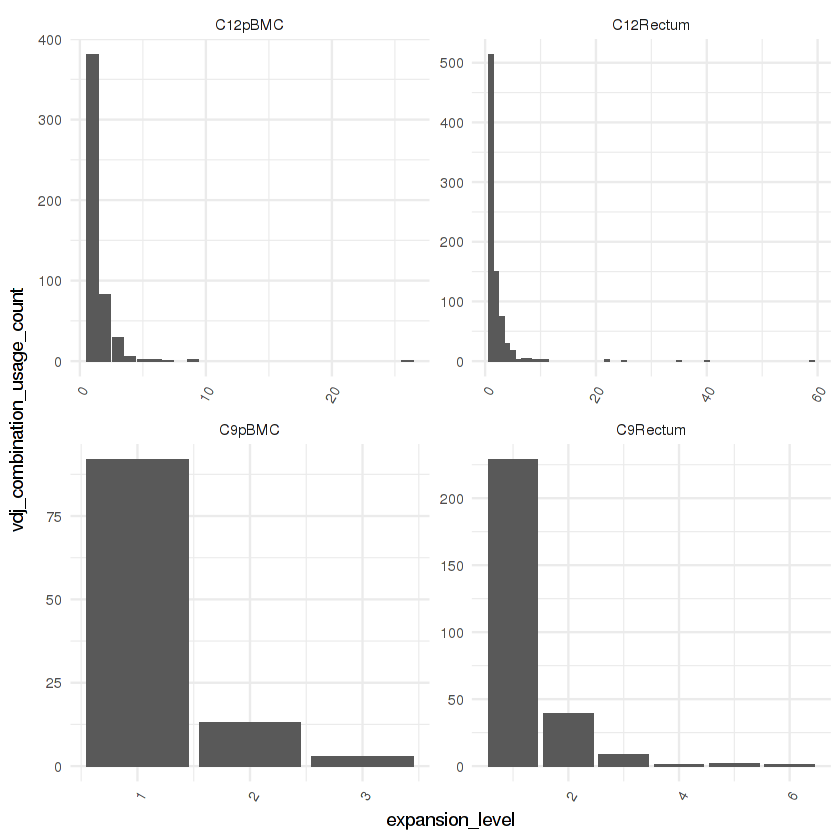

In [7]:
ggplot(clonetype_expansion_count, aes(x=expansion_level_count,y=clone_count)) +
    geom_bar(stat="identity") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "expansion_level", y= "vdj_combination_usage_count") +
    facet_wrap(~groups, nrow = 2, scales = "free")

In [8]:
#shared clone
which(duplicated(clonetype_stat[,c("clone_id","groups")]))

integer(0)

In [9]:
clonetype_stat[1:5,]

,clone_id,count,freq,groups
709,clonetype_315,59,0.03741281,C12Rectum
323,clonetype_39,26,0.03556772,C12pBMC
803,clonetype_513,40,0.02536462,C12Rectum
1319,clonetype_109,3,0.02362205,C9pBMC
1325,clonetype_1115,3,0.02362205,C9pBMC


In [11]:
tag_mat[which(tag_mat$id=="clonetype_513"),]

barcode,v_gene,d_gene,j_gene,c_gene,id
AAACGGGAGCTGCCCA-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AAAGTAGAGCTGATAA-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AAGACCTAGATCCCAT-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AAGGCAGCATCCGTGG-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
ACCTTTAGTATGAATG-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
ACTTTCAAGCGTGTCC-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AGAATAGCAATAGAGT-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AGAGTGGGTTCAGCGC-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
AGTGAGGCATCCAACA-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513
ATCTACTTCATATCGG-2,TRAV12-2,NA,TRAJ58,TRAC,clonetype_513


In [12]:
#B cell
tag_mat=BCR_annoation[valid_TCR_list,c("barcode","v_gene","d_gene","j_gene","c_gene")]
setDT(tag_mat)[, id := paste0("clonetype_",.GRP), by = .(v_gene,d_gene,j_gene,c_gene)]
sample_group=as.numeric(stringi::stri_sub(tag_mat$barcode,-1, -1))
expaned_clone=which(table(tag_mat$id)>1)

plot_table=list()
for(i in 1:max(sample_group)){
    tag=sample_group==i
    tag_id_tbl=table(tag_mat$id[tag])
    plot_table[[i]]=data.frame(clone_id=names(tag_id_tbl),
                               count=as.vector(tag_id_tbl),
                               freq=as.vector(tag_id_tbl)/sum(tag_id_tbl),
                               groups=sample_list[i]) 
}
clonetype_stat=do.call(rbind,plot_table)
clonetype_stat=clonetype_stat[order(clonetype_stat$freq,decreasing = T),]

plot_table=list()
for(i in 1:max(sample_group)){
    tag=clonetype_stat$groups==sample_list[i]
    tag_clonetype_stat=clonetype_stat[tag,]
    tag_freq_tbl=table(tag_clonetype_stat$freq)
    tag_count_tbl=table(tag_clonetype_stat$count)
    plot_table[[i]]=data.frame(groups=sample_list[i],
                               expansion_level=as.numeric(names(tag_freq_tbl)),
                               expansion_level_count=as.numeric(names(tag_count_tbl)),
                               clone_count=as.vector(tag_count_tbl)) 
}
clonetype_expansion_count=do.call(rbind,plot_table)


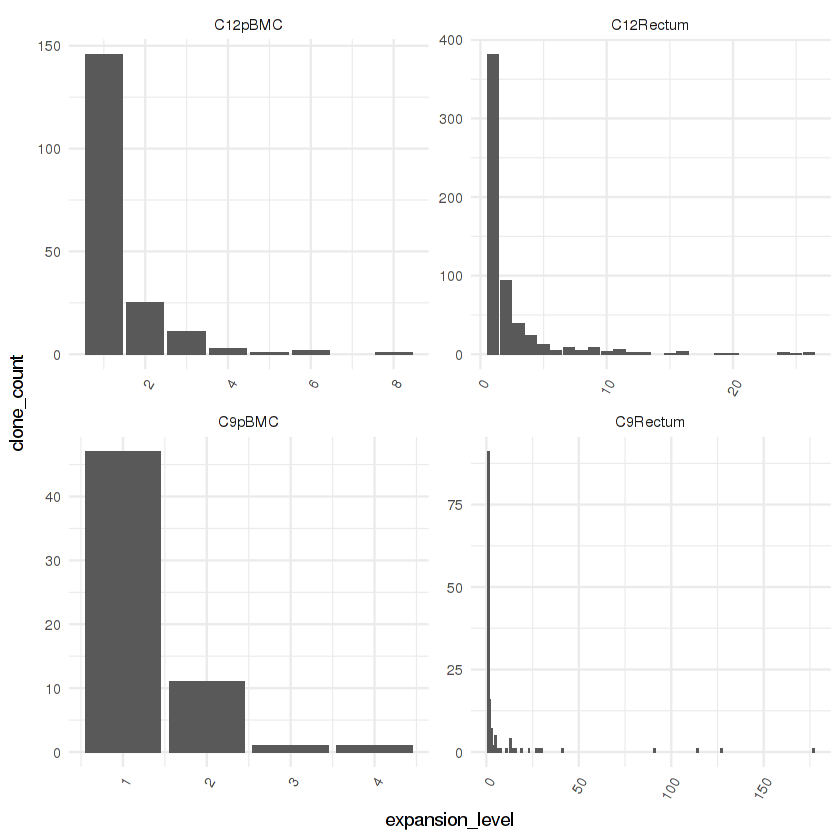

In [13]:
ggplot(clonetype_expansion_count, aes(x=expansion_level_count,y=clone_count)) +
    geom_bar(stat="identity") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "expansion_level", y= "clone_count") +
    facet_wrap(~groups, nrow = 2, scales = "free")

In [14]:
#shared clone
which(duplicated(clonetype_stat[,c("clone_id","groups")]))

integer(0)

# Simple V-D-J useage

In [93]:
sample_group=as.numeric(stringi::stri_sub(BCR_annoation$barcode,-1, -1))

V_table_tmp=list()
top_V=list()
D_table_tmp=list()
top_D=list()
J_table_tmp=list()
top_J=list()
C_table_tmp=list()
top_C=list()
tot_V_list=
for(i in 1:4){
    tag=which(sample_group==i)
    tag_Vtbl=table(BCR_annoation$v_gene[tag])
    V_table_tmp[[i]]=data.frame(gene=names(tag_Vtbl),
                               count=as.vector(tag_Vtbl),
                               freq=as.vector(tag_Vtbl)/sum(as.vector(tag_Vtbl)),
                               group=sample_list[i],stringsAsFactors=F)
    top_V[[i]]=V_table_tmp[[i]]$gene[order(V_table_tmp[[i]]$freq,decreasing = T)[1:10]]
    
    
    tag_Dtbl=table(BCR_annoation$d_gene[tag])
    D_table_tmp[[i]]=data.frame(gene=names(tag_Dtbl),
                               count=as.vector(tag_Dtbl),
                               freq=as.vector(tag_Dtbl)/sum(as.vector(tag_Dtbl)),
                               group=sample_list[i],stringsAsFactors=F)
    top_D[[i]]=D_table_tmp[[i]]$gene[order(D_table_tmp[[i]]$freq,decreasing = T)[1:10]]
    
    tag_Jtbl=table(BCR_annoation$j_gene[tag])
    J_table_tmp[[i]]=data.frame(gene=names(tag_Jtbl),
                               count=as.vector(tag_Jtbl),
                               freq=as.vector(tag_Jtbl)/sum(as.vector(tag_Jtbl)),
                               group=sample_list[i],stringsAsFactors=F)
    top_J[[i]]=J_table_tmp[[i]]$gene[order(J_table_tmp[[i]]$freq,decreasing = T)[1:10]]
    
    tag_Ctbl=table(BCR_annoation$c_gene[tag])
    C_table_tmp[[i]]=data.frame(gene=names(tag_Ctbl),
                               count=as.vector(tag_Ctbl),
                               freq=as.vector(tag_Ctbl)/sum(as.vector(tag_Ctbl)),
                               group=sample_list[i],stringsAsFactors=F)
    top_C[[i]]=C_table_tmp[[i]]$gene[order(C_table_tmp[[i]]$freq,decreasing = T)[1:10]]
}
top_V=unique(unlist(top_V))
V_table=do.call(rbind,V_table_tmp)
V_table=V_table[order(V_table$freq,decreasing = T),]
top_D=unique(unlist(top_D))
D_table=do.call(rbind,D_table_tmp)
D_table=D_table[order(D_table$freq,decreasing = T),]
top_J=unique(unlist(top_J))
J_table=do.call(rbind,J_table_tmp)
J_table=J_table[order(J_table$freq,decreasing = T),]
top_C=unique(unlist(top_C))
C_table=do.call(rbind,C_table_tmp)
C_table=C_table[order(C_table$freq,decreasing = T),]

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

ERROR: Error in data.frame(gene = names(tag_Vtbl), count = as.vector(tag_Vtbl), : arguments imply differing number of rows: 0, 1


In [84]:
V_toplot=V_table[V_table$gene %in% top_V,]
filling_tbl=data.frame(gene=rep(top_V,each=4),count=0,freq=0,group=rep(sample_list,length(top_V)),stringsAsFactors=F)
V_toplot=rbind(V_toplot,filling_tbl)
V_toplot=V_toplot[!duplicated(V_toplot[,c("gene","group")]),]

In [95]:
BCR_annoation[1:5,]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1,AAATGCCTCTGCCCTA-,TRUE,AAATGCCTCTGCCCTA-1_contig_1,TRUE,570,IGK,IGKV3-15,NA,IGKJ4,IGKC,TRUE,TRUE,CQQYNNWPPLTF,TGTCAGCAGTATAATAACTGGCCTCCGCTCACTTTC,807,25,clonotype6,clonotype6_consensus_1
2,AACCGCGAGAAACCGC-,TRUE,AACCGCGAGAAACCGC-1_contig_1,TRUE,557,IGL,IGLV3-19,NA,IGLJ2,IGLC2,TRUE,TRUE,CNSRDSSGNHLKVVF,TGTAACTCCCGGGACAGCAGTGGTAACCATCTAAAGGTGGTATTC,149,8,clonotype7,clonotype7_consensus_1
3,AACCGCGAGAAACCGC-,TRUE,AACCGCGAGAAACCGC-1_contig_2,TRUE,334,IGH,IGHV7-81,NA,NA,NA,FALSE,NA,NA,NA,48,3,clonotype7,NA
5,AACTCTTCAATAGCAA-,TRUE,AACTCTTCAATAGCAA-1_contig_1,TRUE,552,IGK,IGKV1-5,NA,IGKJ2,IGKC,TRUE,TRUE,CQQYNSYSYTF,TGCCAACAGTATAATAGTTATTCTTACACTTTT,957,30,clonotype20,clonotype20_consensus_2
6,AACTCTTCAATAGCAA-,TRUE,AACTCTTCAATAGCAA-1_contig_2,TRUE,552,IGH,IGHV1-2,IGHD1-14,IGHJ3,IGHM,TRUE,TRUE,CARDPIGADGAFDVW,TGTGCGAGAGATCCAATCGGAGCCGATGGTGCTTTTGATGTCTGG,137,12,clonotype20,clonotype20_consensus_1


In [61]:
duplicated(V_table[V_table$gene=="IGHV1-18",][,c("gene","group")])

[1] FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE

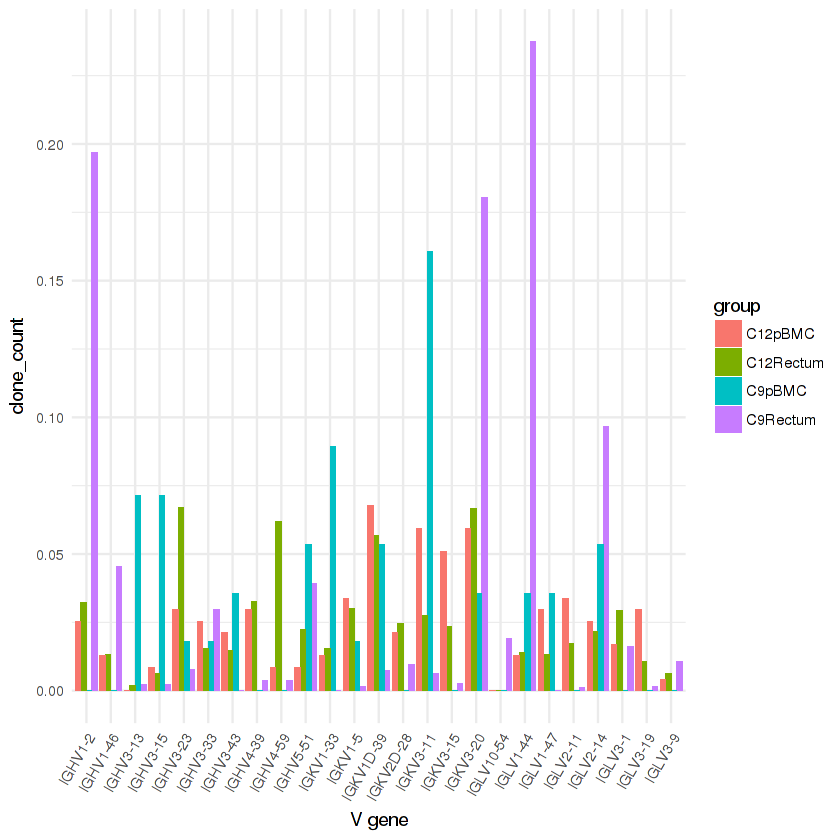

In [85]:
ggplot(V_toplot, aes(x=gene,y=freq,fill=group)) +
    geom_bar(stat="identity", position=position_dodge()) +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "V gene", y= "clone_count")

In [86]:
V_toplot[V_toplot$group=="C9Rectum",]

,gene,count,freq,group
221,IGLV1-44,450,0.237467018,C9Rectum
176,IGHV1-2,373,0.196833773,C9Rectum
216,IGKV3-20,342,0.180474934,C9Rectum
224,IGLV2-14,183,0.096569921,C9Rectum
178,IGHV1-46,86,0.045382586,C9Rectum
198,IGHV5-51,74,0.039050132,C9Rectum
185,IGHV3-33,56,0.029551451,C9Rectum
219,IGLV10-54,36,0.018997361,C9Rectum
226,IGLV3-1,31,0.016358839,C9Rectum
231,IGLV3-9,20,0.010554090,C9Rectum


In [12]:
for(i in 1:4){
    
}


V_table[1:10,]
D_table[1:10,]
J_table[1:10,]
C_table[1:10,]

,v_gene,count,freq,group
271,IGHV1-2,465,0.17547170,C9Rectum
324,IGLV1-44,456,0.17207547,C9Rectum
319,IGKV3-20,447,0.16867925,C9Rectum
275,IGHV1-46,383,0.14452830,C9Rectum
243,IGKV3-11,10,0.08474576,C9pBMC
251,IGLV2-14,10,0.08474576,C9pBMC
327,IGLV2-14,193,0.07283019,C9Rectum
298,IGHV5-51,174,0.06566038,C9Rectum
167,IGKV3-20,145,0.06476105,C12Rectum
117,IGHV3-23,140,0.06252791,C12Rectum


,d_gene,count,freq,group
71,IGHD2-8,408,0.50061350,C9Rectum
63,IGHD6-19,7,0.25000000,C9pBMC
69,IGHD2-2,155,0.19018405,C9Rectum
55,IGHD2-2,4,0.14285714,C9pBMC
60,IGHD4-17,4,0.14285714,C9pBMC
2,IGHD1-26,12,0.12000000,C12pBMC
20,IGHD6-19,11,0.11000000,C12pBMC
58,IGHD3-22,3,0.10714286,C9pBMC
19,IGHD6-13,10,0.10000000,C12pBMC
36,IGHD3-22,93,0.09528689,C12Rectum


,j_gene,count,freq,group
57,IGHJ3,672,0.3134328,C9Rectum
67,IGLJ2,522,0.2434701,C9Rectum
20,IGHJ4,504,0.2326870,C12Rectum
41,IGHJ4,18,0.1855670,C9pBMC
61,IGKJ1,388,0.1809701,C9Rectum
51,IGLJ3,15,0.1546392,C9pBMC
3,IGHJ4,49,0.1540881,C12pBMC
12,IGLJ2,42,0.1320755,C12pBMC
6,IGKJ1,39,0.1226415,C12pBMC
47,IGKJ4,11,0.1134021,C9pBMC


,c_gene,count,freq,group
13,IGHA2,803,0.3741845,C12Rectum
28,IGKC,36,0.3636364,C9pBMC
8,IGKC,114,0.3465046,C12pBMC
17,IGKC,718,0.3345760,C12Rectum
40,IGLC2,597,0.3253406,C9Rectum
7,IGHM,91,0.2765957,C12pBMC
32,IGHA1,443,0.2414169,C9Rectum
38,IGKC,440,0.2397820,C9Rectum
30,IGLC2,21,0.2121212,C9pBMC
10,IGLC2,67,0.2036474,C12pBMC


In [ ]:
# 

In [1]:
ls()

character(0)